[WARNING] ME(30262:132595847530048,MainProcess):2025-04-03-14:41:19.151.000 [mindspore/context.py:1335] For 'context.set_context', the parameter 'device_target' will be deprecated and removed in a future version. Please use the api mindspore.set_device() instead.


The type of mnist_ds: <class 'mindspore.dataset.engine.datasets_vision.MnistDataset'>
Number of pictures contained in the mnist_ds： 60000
The item of mnist_ds: dict_keys(['image', 'label'])
Tensor of image in item: (28, 28, 1)
The label of item: 4


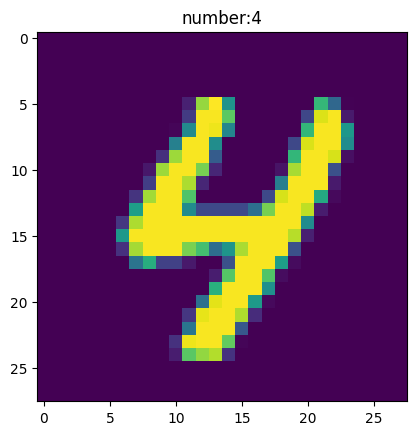

In [7]:
from mindspore import context
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import mindspore.dataset as ds

context.set_context(mode=context.GRAPH_MODE,
                    device_target="CPU")  # Windows version, set to use CPU for graph calculation
train_data_path = "./data/train"
test_data_path = "./data/test"
mnist_ds = ds.MnistDataset(train_data_path)  # Load training dataset
print('The type of mnist_ds:', type(mnist_ds))
print("Number of pictures contained in the mnist_ds：", mnist_ds.get_dataset_size())  # 60000 pictures in total

dic_ds = mnist_ds.create_dict_iterator()  # Convert dataset to dictionary type
item = dic_ds.__next__()
img = item["image"].asnumpy()
label = item["label"].asnumpy()

print("The item of mnist_ds:",
      item.keys())  # Take a single data to view the data structure, including two keys, image and label
print("Tensor of image in item:", img.shape)  # View the tensor of image (28,28,1)
print("The label of item:", label)

plt.imshow(np.squeeze(img))
plt.title("number:%s" % item["label"])
plt.show()

In [8]:
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.dataset.vision import Inter
from mindspore.common import dtype as mstype


def create_dataset(data_path, batch_size=32, repeat_size=1,
                   num_parallel_workers=1):
    """ create dataset for train or test
    Args:
        data_path: Data path
        batch_size: The number of data records in each group
        repeat_size: The number of replicated data records
        num_parallel_workers: The number of parallel workers
    """
    # define dataset
    mnist_ds = ds.MnistDataset(data_path)

    # Define some parameters needed for data enhancement and rough justification
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081

    # According to the parameters, generate the corresponding data enhancement method
    resize_op = CV.Resize((resize_height, resize_width),
                          interpolation=Inter.LINEAR)  # Resize images to (32, 32) by bilinear interpolation
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml)  # normalize images
    rescale_op = CV.Rescale(rescale, shift)  # rescale images
    hwc2chw_op = CV.HWC2CHW()  # change shape from (height, width, channel) to (channel, height, width) to fit network.
    type_cast_op = C.TypeCast(mstype.int32)  # change data type of label to int32 to fit network

    # Using map () to apply operations to a dataset
    mnist_ds = mnist_ds.map(input_columns="label", operations=type_cast_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=resize_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=rescale_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=rescale_nml_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=hwc2chw_op, num_parallel_workers=num_parallel_workers)
    # Process the generated dataset
    buffer_size = 10000
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size)  # 10000 as in LeNet train script
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)
    mnist_ds = mnist_ds.repeat(repeat_size)

    return mnist_ds

In [9]:
datas = create_dataset(train_data_path)  # Process the train dataset
print('Number of groups in the dataset:', datas.get_dataset_size())  # Number of query dataset groups

[WARNING] ME(30262:132595847530048,MainProcess):2025-04-03-14:43:47.262.000 [mindspore/dataset/core/validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(30262:132595847530048,MainProcess):2025-04-03-14:43:47.263.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(30262:132595847530048,MainProcess):2025-04-03-14:43:47.264.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(30262:132595847530048,MainProcess):2025-04-03-14:43:47.265.000 [mindspore/dat

Number of groups in the dataset: 1875


In [10]:
data = datas.create_dict_iterator().__next__()  # Take a set of datasets
print(data.keys())
images = data["image"].asnumpy()  # Take out the image data in this dataset
labels = data["label"].asnumpy()  # Take out the label (subscript) of this data set
print('Tensor of image:', images.shape)  # Query the tensor of images in each dataset (32,1,32,32)
print('labels:', labels)

dict_keys(['image', 'label'])
Tensor of image: (32, 1, 32, 32)
labels: [3 9 2 0 7 0 7 4 6 4 7 3 7 3 8 1 9 9 0 7 5 4 1 2 6 7 0 3 2 9 6 4]


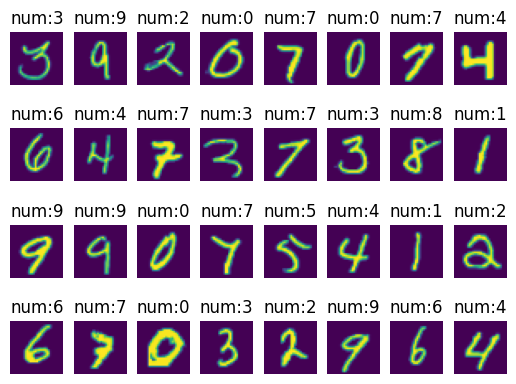

In [11]:
count = 1
for i in images:
    plt.subplot(4, 8, count)
    plt.imshow(np.squeeze(i))
    plt.title('num:%s' % labels[count - 1])
    plt.xticks([])
    count += 1
    plt.axis("off")
plt.show()  # Print a total of 32 pictures in the group

In [12]:
import mindspore.nn as nn
from mindspore.common.initializer import TruncatedNormal


# Initialize 2D convolution function
def conv(in_channels, out_channels, kernel_size, stride=1, padding=0):
    """Conv layer weight initial."""
    weight = weight_variable()
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight, has_bias=False, pad_mode="valid")


# Initialize full connection layer
def fc_with_initialize(input_channels, out_channels):
    """Fc layer weight initial."""
    weight = weight_variable()
    bias = weight_variable()
    return nn.Dense(input_channels, out_channels, weight, bias)


# Set truncated normal distribution
def weight_variable():
    """Weight initial."""
    return TruncatedNormal(0.02)

In [13]:
class LeNet5(nn.Cell):
    """Lenet network structure."""

    # define the operator required
    def __init__(self):
        super(LeNet5, self).__init__()
        self.batch_size = 32  # 32 pictures in each group
        self.conv1 = conv(1, 6,
                          5)  # Convolution layer 1, 1 channel input (1 Figure), 6 channel output (6 figures), convolution core 5 * 5
        self.conv2 = conv(6, 16, 5)  # Convolution layer 2,6-channel input, 16 channel output, convolution kernel 5 * 5
        self.fc1 = fc_with_initialize(16 * 5 * 5, 120)
        self.fc2 = fc_with_initialize(120, 84)
        self.fc3 = fc_with_initialize(84, 10)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    # use the preceding operators to construct networks
    def construct(self, x):
        x = self.conv1(x)  # 1*32*32-->6*28*28
        x = self.relu(x)  # 6*28*28-->6*14*14
        x = self.max_pool2d(x)  # Pool layer
        x = self.conv2(x)  # Convolution layer
        x = self.relu(x)  # Function excitation layer
        x = self.max_pool2d(x)  # Pool layer
        x = self.flatten(x)  # Dimensionality reduction
        x = self.fc1(x)  # Full connection
        x = self.relu(x)  # Function excitation layer
        x = self.fc2(x)  # Full connection
        x = self.relu(x)  # Function excitation layer
        x = self.fc3(x)  # Full connection
        return x

In [14]:
network = LeNet5()
print(network)

LeNet5<
  (conv1): Conv2d<input_channels=1, output_channels=6, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.TruncatedNormal object at 0x7897c4321ea0>, bias_init=None, format=NCHW>
  (conv2): Conv2d<input_channels=6, output_channels=16, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.TruncatedNormal object at 0x7897d7a174f0>, bias_init=None, format=NCHW>
  (fc1): Dense<input_channels=400, output_channels=120, has_bias=True>
  (fc2): Dense<input_channels=120, output_channels=84, has_bias=True>
  (fc3): Dense<input_channels=84, output_channels=10, has_bias=True>
  (relu): ReLU<>
  (max_pool2d): MaxPool2d<kernel_size=2, stride=2, pad_mode=VALID>
  (flatten): Flatten<>
  >


In [15]:
param = network.trainable_params()
param

[Parameter (name=conv1.weight, shape=(6, 1, 5, 5), dtype=Float32, requires_grad=True),
 Parameter (name=conv2.weight, shape=(16, 6, 5, 5), dtype=Float32, requires_grad=True),
 Parameter (name=fc1.weight, shape=(120, 400), dtype=Float32, requires_grad=True),
 Parameter (name=fc1.bias, shape=(120,), dtype=Float32, requires_grad=True),
 Parameter (name=fc2.weight, shape=(84, 120), dtype=Float32, requires_grad=True),
 Parameter (name=fc2.bias, shape=(84,), dtype=Float32, requires_grad=True),
 Parameter (name=fc3.weight, shape=(10, 84), dtype=Float32, requires_grad=True),
 Parameter (name=fc3.bias, shape=(10,), dtype=Float32, requires_grad=True)]

In [16]:
# Training and testing related modules
import argparse
import os
from mindspore import Tensor
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor,Callback
from mindspore.train import Model
from mindspore.nn.metrics import Accuracy
from mindspore.nn.loss import SoftmaxCrossEntropyWithLogits

def train_net(model, epoch_size, mnist_path, repeat_size, ckpoint_cb, step_loss_info):
    """Define the training method."""
    print("============== Starting Training ==============")
    # load training dataset
    ds_train = create_dataset(os.path.join(mnist_path, "train"), 32, repeat_size)
    model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, LossMonitor(), step_loss_info], dataset_sink_mode=True)

In [17]:
# Custom callback function
class Step_loss_info(Callback):
    def step_end(self, run_context):
        cb_params = run_context.original_args()
        # step_ Loss dictionary for saving loss value and step number information
        step_loss["loss_value"].append(str(cb_params.net_outputs))
        step_loss["step"].append(str(cb_params.cur_step_num))

In [19]:
import os

if os.name == "nt":
    os.system('del/f/s/q *.ckpt *.meta')# Clean up old run files before in Windows
else:
    os.system('rm -f *.ckpt *.meta *.pb')# Clean up old run files before in Linux

lr = 0.01 # learning rate
momentum = 0.9 #

# create the network
network = LeNet5()

# define the optimizer
net_opt = nn.Momentum(network.trainable_params(), lr, momentum)


# define the loss function
net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
# define the model
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()} )
epoch_size = 10
mnist_path = "./data"

config_ck = CheckpointConfig(save_checkpoint_steps=125, keep_checkpoint_max=16)
# save the network model and parameters for subsequence fine-tuning

ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", config=config_ck)
# group layers into an object with training and evaluation features
step_loss = {"step": [], "loss_value": []}
# step_ Loss dictionary for saving loss value and step number information
step_loss_info = Step_loss_info()
# save the steps and loss value
repeat_size = 1
train_net(model, epoch_size, mnist_path, repeat_size, ckpoint_cb, step_loss_info)

[WARNING] ME(30262:132595847530048,MainProcess):2025-04-03-14:51:44.544.000 [mindspore/dataset/core/validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(30262:132595847530048,MainProcess):2025-04-03-14:51:44.544.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(30262:132595847530048,MainProcess):2025-04-03-14:51:44.545.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(30262:132595847530048,MainProcess):2025-04-03-14:51:44.545.000 [mindspore/dat

============== Starting Training ==============
epoch: 1 step: 1, loss is 2.3007149696350098
epoch: 1 step: 2, loss is 2.3027236461639404
epoch: 1 step: 3, loss is 2.301825523376465
epoch: 1 step: 4, loss is 2.2992844581604004
epoch: 1 step: 5, loss is 2.3038063049316406
epoch: 1 step: 6, loss is 2.3020694255828857
epoch: 1 step: 7, loss is 2.3010506629943848
epoch: 1 step: 8, loss is 2.3047430515289307
epoch: 1 step: 9, loss is 2.300079107284546
epoch: 1 step: 10, loss is 2.3057174682617188
epoch: 1 step: 11, loss is 2.300433397293091
epoch: 1 step: 12, loss is 2.302960157394409
epoch: 1 step: 13, loss is 2.3048901557922363
epoch: 1 step: 14, loss is 2.2989909648895264
epoch: 1 step: 15, loss is 2.3006248474121094
epoch: 1 step: 16, loss is 2.3031868934631348
epoch: 1 step: 17, loss is 2.3056387901306152
epoch: 1 step: 18, loss is 2.2969870567321777
epoch: 1 step: 19, loss is 2.295560121536255
epoch: 1 step: 20, loss is 2.3088691234588623
epoch: 1 step: 21, loss is 2.3032989501953125


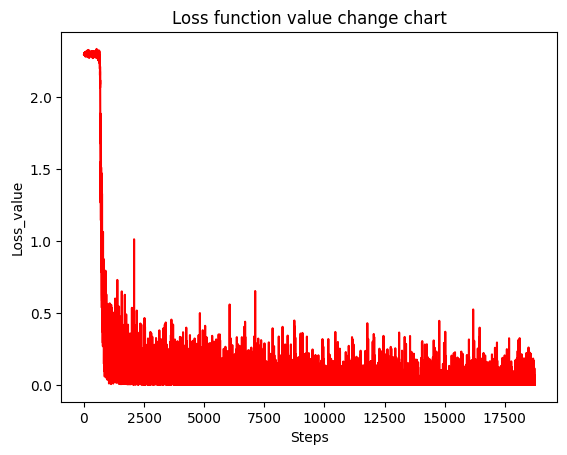

In [20]:
steps = step_loss["step"]
loss_value = step_loss["loss_value"]
steps = list(map(int, steps))
loss_value = list(map(float, loss_value))
plt.plot(steps, loss_value, color="red")
plt.xlabel("Steps")
plt.ylabel("Loss_value")
plt.title("Loss function value change chart")
plt.show()

In [21]:
def test_net(network, model, mnist_path):
    """Define the evaluation method."""
    print("============== Starting Testing ==============")
    # load the saved model for evaluation
    param_dict = load_checkpoint("checkpoint_lenet-10_1875.ckpt")
    # load parameter to the network
    load_param_into_net(network, param_dict)
    # load testing dataset
    ds_eval = create_dataset(os.path.join(mnist_path, "test"))
    acc = model.eval(ds_eval, dataset_sink_mode=True)
    print("============== Accuracy:{} ==============".format(acc))

test_net(network, model, mnist_path)

[WARNING] ME(30262:132595847530048,MainProcess):2025-04-03-15:04:45.759.000 [mindspore/dataset/core/validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(30262:132595847530048,MainProcess):2025-04-03-15:04:45.761.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(30262:132595847530048,MainProcess):2025-04-03-15:04:45.761.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(30262:132595847530048,MainProcess):2025-04-03-15:04:45.762.000 [mindspore/dat

============== Starting Testing ==============
============== Accuracy:{'Accuracy': 0.9888822115384616} ==============


[WARNING] ME(30262:132595847530048,MainProcess):2025-04-03-15:05:46.810.000 [mindspore/dataset/core/validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(30262:132595847530048,MainProcess):2025-04-03-15:05:46.811.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(30262:132595847530048,MainProcess):2025-04-03-15:05:46.812.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(30262:132595847530048,MainProcess):2025-04-03-15:05:46.812.000 [mindspore/dat

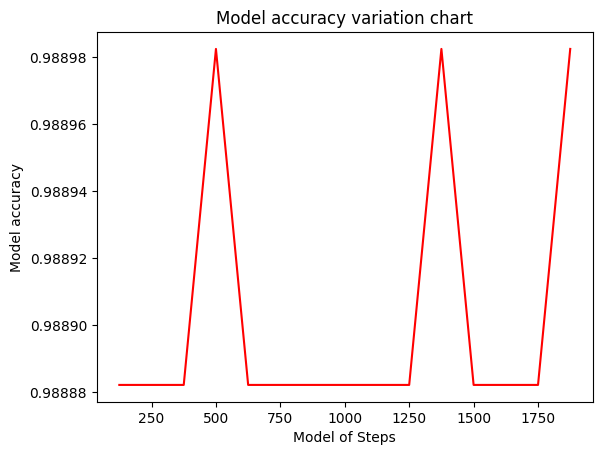

In [23]:
def acc_model_info(network, model, mnist_path, model_numbers, epoch_size):
    """Define the plot info method"""
    step_list = []
    acc_list = []
    for i in range(1, epoch_size +1):
        # load the saved model for evaluation
        #加载同一个模型得到的模型训练步数变化，精度随之变化
        param_dict = load_checkpoint("checkpoint_lenet-10_1875.ckpt")
        #加载不同一个模型得到的模型训练步数变化，精度随之变化
        #param_dict = load_checkpoint("checkpoint_lenet-{}_1875.ckpt".format(str(i)))

        # load parameter to the network
        load_param_into_net(network, param_dict)
        # load testing dataset
    for i in range(1, model_numbers +1):
        ds_eval = create_dataset(os.path.join(mnist_path, "test"))
        acc = model.eval(ds_eval, dataset_sink_mode=True)
        acc_list.append(acc['Accuracy'])
        step_list.append(i*125)
    return step_list,acc_list

# Draw line chart according to training steps and model accuracy
l1,l2 = acc_model_info(network, model, mnist_path, 15, 10)
plt.xlabel("Model of Steps")
plt.ylabel("Model accuracy")
plt.title("Model accuracy variation chart")
plt.plot(l1, l2, 'red')
plt.show()

[WARNING] ME(30262:132595847530048,MainProcess):2025-04-03-15:06:34.165.000 [mindspore/dataset/core/validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(30262:132595847530048,MainProcess):2025-04-03-15:06:34.166.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(30262:132595847530048,MainProcess):2025-04-03-15:06:34.167.000 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(30262:132595847530048,MainProcess):2025-04-03-15:06:34.167.000 [mindspore/dat

Row 3, column 7 is incorrectly identified as 4, the correct value should be 9 

[1 7 7 4 9 1 4 4 2 7 8 2 8 4 8 4 9 2 5 0 6 6 4 9 7 2 5 6 8 1 7 9] <--Predicted figures
[1 7 7 4 9 1 4 4 2 7 8 2 8 4 8 4 9 2 5 0 6 6 9 9 7 2 5 6 8 1 7 9] <--The right number


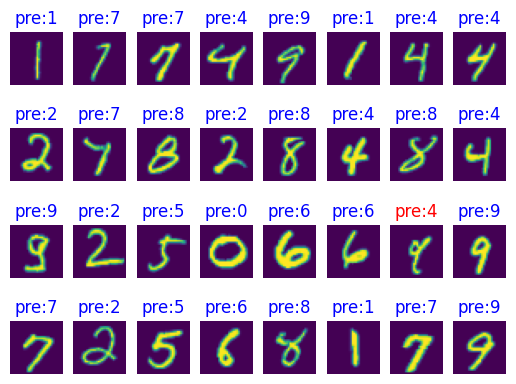

In [24]:
ds_test = create_dataset(test_data_path).create_dict_iterator()
data = ds_test.__next__()
images = data["image"].asnumpy()
labels = data["label"].asnumpy() # The subscript of data picture is the standard for us to judge whether it is correct or not

output =model.predict(Tensor(data['image']))
# The predict function returns the probability of 0-9 numbers corresponding to each picture
prb = output.asnumpy()
pred = np.argmax(output.asnumpy(), axis=1)
err_num = []
index = 1
for i in range(len(labels)):
    plt.subplot(4, 8, i+1)
    color = 'blue' if pred[i] == labels[i] else 'red'
    plt.title("pre:{}".format(pred[i]), color=color)
    plt.imshow(np.squeeze(images[i]))
    plt.axis("off")
    if color == 'red':
        index = 0
        # Print out the wrong data identified by the current group
        print("Row {}, column {} is incorrectly identified as {}, the correct value should be {}".format(int(i/8)+1, i%8+1, pred[i], labels[i]), '\n')
if index:
    print("All the figures in this group are predicted correctly！")
print(pred, "<--Predicted figures") # Print the numbers recognized by each group of pictures
print(labels, "<--The right number") # Print the subscript corresponding to each group of pictures
plt.show()

Figure 1 probability of corresponding numbers [0-9]:
 [-4.619632   11.049773   -1.058803   -3.6434796   0.7165255  -0.71282876
  0.74135077  1.3543155  -1.8832588  -1.9515005 ]


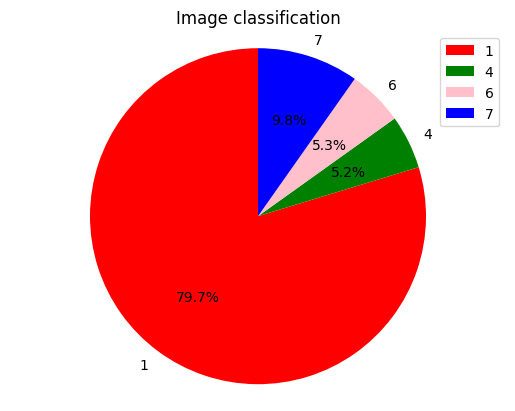

Figure 2 probability of corresponding numbers [0-9]:
 [-2.7222958   6.2951527  -1.4805734  -3.677535   -0.82885605 -3.2688353
 -6.4579587  10.616985   -1.9450471   3.5981624 ]


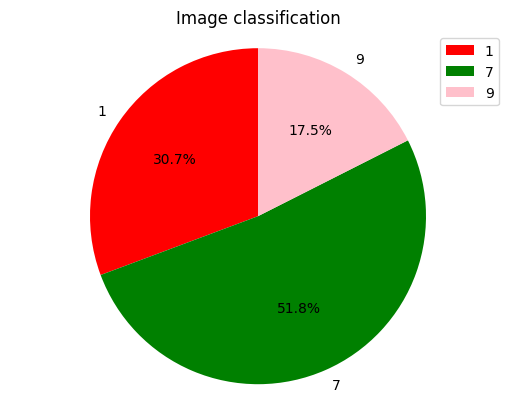

In [25]:
# define the pie drawing function of probability analysis
def plot_pie(prbs):
    dict1 = {}
    # Remove the negative number and build the dictionary dict1. The key is the number and the value is the probability value
    for i in range(10):
        if prbs[i] > 0:
            dict1[str(i)] = prbs[i]

    label_list = dict1.keys()    # Label of each part
    size = dict1.values()    # Size of each part
    colors = ["red", "green", "pink", "blue", "purple", "orange", "gray"] # Building a round cake pigment Library
    color = colors[: len(size)]# Color of each part
    plt.pie(size, colors=color, labels=label_list, labeldistance=1.1, autopct="%1.1f%%", shadow=False, startangle=90, pctdistance=0.6)
    plt.axis("equal")    # Set the scale size of x-axis and y-axis to be equal
    plt.legend()
    plt.title("Image classification")
    plt.show()


for i in range(2):
    print("Figure {} probability of corresponding numbers [0-9]:\n".format(i+1), prb[i])
    plot_pie(prb[i])